# 추천시스템 설명
https://datascienceschool.net/view-notebook/fcd3550f11ac4537acec8d18136f2066/
#https://yamalab.tistory.com/69

# MF Recommender 구현

In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [24]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import numpy as np
import math


In [15]:
dataset=pd.read_csv("us5500.data", sep="\t",names=["user_id","item_id","rating","timestamp"])
dataset.head()
#len(dataset.user_id)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [21]:
# so same! like nunique 랑 unique len
# len(dataset.user_id.unique())
dataset.user_id.nunique()

342

# datatype을 원핫 인코딩으로 바꾼 것 이다.
#유니크한 user_id를 가져와서

In [16]:
dataset.user_id=dataset.user_id.astype("category").cat.codes.values
dataset.item_id=dataset.item_id.astype("category").cat.codes.values
dataset.head()

,user_id,item_id,rating,timestamp
0,194,233,3,881250949
1,184,291,3,891717742
2,21,361,1,878887116
3,242,47,2,880606923
4,164,334,1,886397596


# train 과 test split!

In [22]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(dataset,test_size=0.2)

print(train.user_id)

1852    172
1019    237
4168    310
3001     90
595     267
3780    281
432     220
213     179
4890    232
1068    174
330     126
272     298
1418    232
1000    310
1519    174
5105    248
2238     25
5381    273
3928    220
95      117
4724    283
36      179
4642     60
2719    212
390      20
1088     85
4909     82
3934    195
2176    179
1209     92
       ... 
1607    269
2389    266
3900    192
531     127
3119    312
2518    172
3958    181
553     228
965     184
2461     14
937       6
2893    269
2375    230
3023    294
3239     99
4863    100
4649    215
2707    302
3495    142
3670     71
3787    156
2531    145
1158    141
3114     12
2988    187
693     232
864     102
3258    117
1329      3
2529    295
Name: user_id, Length: 4400, dtype: int16


# keras 이용 해서 하이브리드 모델 생성

In [58]:
import keras
from keras.models import Model

n_users, n_movies= len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors=3

In [59]:
movie_input=keras.layers.Input(shape=[1],name="item")

movie_embedding=keras.layers.Embedding(n_movies+1, n_latent_factors, name="Movie-Embedding")(movie_input) # input 으로 받아서 embedding 넘김
movie_vec=keras.layers.Flatten(name="FlattenMovies")(movie_embedding)


user_input=keras.layers.Input(shape=[1],name="User")

user_embedding=keras.layers.Embedding(n_users+1, n_latent_factors, name="User-Embedding")(user_input)
user_vec=keras.layers.Flatten(name="Flatten")(user_embedding)

# 두개의 노드 합치기
prod=keras.layers.dot([movie_vec,user_vec], axes=1,normalize=False, name="DotProduct")

model=Model([user_input,movie_input],prod)
model.compile("adam","mean_squared_error")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         3288        item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         1029        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

# Non-Negative

In [55]:
import keras
from keras.models import Model
from keras.constraints import non_neg

n_users, n_movies= len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors=3

movie_input=keras.layers.Input(shape=[1],name="item")

movie_embedding=keras.layers.Embedding(n_movies+1, n_latent_factors, name="NonNegMovie-Embedding", embeddings_constraint=non_neg)(movie_input) # input 으로 받아서 embedding 넘김
movie_vec=keras.layers.Flatten(name="FlattenMovies")(movie_embedding)


user_input=keras.layers.Input(shape=[1],name="User")

user_embedding=keras.layers.Embedding(n_users+1, n_latent_factors, name="NonNegUser-Embedding",embeddings_constraint=non_neg)(user_input)
user_vec=keras.layers.Flatten(name="Flatten")(user_embedding)

# 두개의 노드 합치기
prod=keras.layers.dot([movie_vec,user_vec], axes=1,normalize=False, name="DotProduct")

model=Model([user_input,movie_input],prod)
model.compile("adam","mean_squared_error")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         3288        item[0][0]                       
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         1029        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [60]:
history=model.fit([train.user_id,train.item_id], train.rating, epochs=50, verbose=0)

y_hat=np.round(model.predict([test.user_id, test.item_id]),0)
y_true=test.rating

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_true,y_hat))

1.6254545454545455


# train 에 있는 데이터를 validation으로 나눈다.

1.4072727272727272


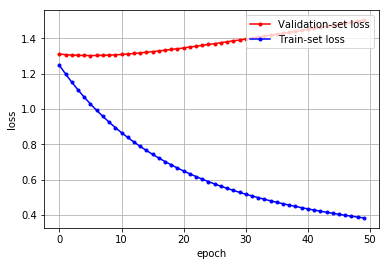

In [61]:
history=model.fit([train.user_id,train.item_id], train.rating,validation_split=0.2 ,epochs=50, verbose=0)
y_vloss=history.history["val_loss"]
y_loss=history.history["loss"]

x_len=np.arange(len(y_loss))
plt.plot(x_len,y_vloss,marker=".", c="red", label="Validation-set loss")
plt.plot(x_len,y_loss,marker=".", c="blue", label="Train-set loss")


plt.legend(loc="upper right")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

y_hat=np.round(model.predict([test.user_id, test.item_id]),0)
y_true=test.rating
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_true,y_hat))

# 2. Nearal CF 사용하여 추천시스템

#convolution 층과 fully-connected 층은 개념이 상반된다.
#완전연결, 모든 노드들이 = Dense
#convoultion 층은 필터로 연결 일부만 연결된다.필터를 통해서 필터링, 가중치의 갯수를 줄이는 개념. 대신에 깊게 쌓겠다.

#flatten 과 Dense의 차이??Flatten은 한줄로 연결이고 Dense= 풀리 커넥티드 층.


#3개의 은닉층을 가진 MLP를 사용


# NCF recommender

In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [64]:
dataset=pd.read_csv("us5500.data",sep="\t",names=["user_id","item_id","rating","timestamp"])

In [65]:
dataset.user_id=dataset.user_id.astype("category").cat.codes.values
dataset.item_id=dataset.item_id.astype("category").cat.codes.values
dataset.head()

,user_id,item_id,rating,timestamp
0,194,233,3,881250949
1,184,291,3,891717742
2,21,361,1,878887116
3,242,47,2,880606923
4,164,334,1,886397596


In [67]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(dataset,test_size=0.2)

In [72]:
import keras
from keras.optimizers import Adam
from keras.models import Model

# 이때 차원의 수를 나눠줌, 인풋이 하이브리드
n_users, n_movies= len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors=3

movie_input=keras.layers.Input(shape=[1],name="item")
movie_embedding=keras.layers.Embedding(n_movies+1, n_latent_factors, name="NonNegMovie-Embedding")(movie_input) # input 으로 받아서 embedding 넘김
movie_vec=keras.layers.Flatten(name="FlattenMovies")(movie_embedding)
movie_vec=keras.layers.Dropout(0.2)(movie_vec)

user_input=keras.layers.Input(shape=[1],name="User")
user_embedding=keras.layers.Embedding(n_users+1, n_latent_factors, name="NonNegUser-Embedding")(user_input)
user_vec=keras.layers.Flatten(name="Flatten")(user_embedding)
user_vec=keras.layers.Dropout(0.2)(user_vec)

W0821 16:24:02.796692 14072 deprecation.py:506] From C:\Users\Affinity\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [78]:
from keras.layers  import concatenate
concat=concatenate([movie_vec,user_vec],name="Concat")

layer_1 = keras.layers.Dense(20,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout_1')(layer_1)

layer_2 = keras.layers.Dense(10,name='FullyConnected-1')(dropout_1)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout_2')(layer_2)

layer_3 = keras.layers.Dense(5,name='FullyConnected-2')(dropout_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(layer_3)

layer_4 = keras.layers.Dense(3,name='FullyConnected-3', activation='relu')(dropout_3)

In [79]:
result=keras.layers.Dense(1,activation="relu", name="Activation")(layer_4)
adam=Adam(lr=0.005)
model=Model([user_input,movie_input],result)
model.compile(optimizer=adam,loss="mean_absolute_error")

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         3288        item[0][0]                       
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         1029        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

0.8263636363636364


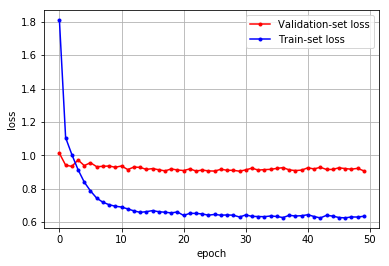

In [80]:
history=model.fit([train.user_id,train.item_id], train.rating,validation_split=0.2 ,epochs=50, verbose=0)
y_vloss=history.history["val_loss"]
y_loss=history.history["loss"]

x_len=np.arange(len(y_loss))
plt.plot(x_len,y_vloss,marker=".", c="red", label="Validation-set loss")
plt.plot(x_len,y_loss,marker=".", c="blue", label="Train-set loss")


plt.legend(loc="upper right")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

y_hat=np.round(model.predict([test.user_id, test.item_id]),0)
y_true=test.rating
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_true,y_hat))

# Batchnormalization

In [82]:
import keras
from keras.models import Model
n_latent_factors_user = 5
n_latent_factors_movie = 8
n_latent_factors_mf = 3
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)

from keras.layers import concatenate
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.dot([movie_vec_mf, user_vec_mf], name='Dot',  axes=1)
#keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False, name='DotProduct')

pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.concatenate([pred_mf, pred_mlp],name='Concat-MF-MLP')

result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')
model.summary()

history = model.fit([train.user_id, train.item_id], train.rating, epochs=50, verbose=0, validation_split=0.1)

from sklearn.metrics import mean_absolute_error
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding-MLP (Embedding) (None, 1, 8)         8768        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 5)         1715        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

0.9272727272727272


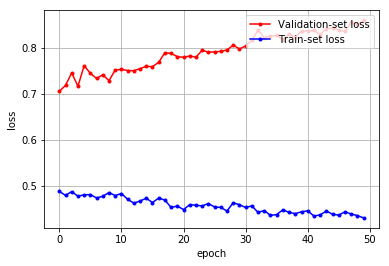

In [83]:
history=model.fit([train.user_id,train.item_id], train.rating,validation_split=0.2 ,epochs=50, verbose=0)
y_vloss=history.history["val_loss"]
y_loss=history.history["loss"]

x_len=np.arange(len(y_loss))
plt.plot(x_len,y_vloss,marker=".", c="red", label="Validation-set loss")
plt.plot(x_len,y_loss,marker=".", c="blue", label="Train-set loss")


plt.legend(loc="upper right")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

y_hat=np.round(model.predict([test.user_id, test.item_id]),0)
y_true=test.rating
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_true,y_hat))